# Задание 5.1 - Word2Vec

В этом задании мы натренируем свои word vectors на очень небольшом датасете.
Мы будем использовать самую простую версию word2vec, без negative sampling и других оптимизаций.

Перед запуском нужно запустить скрипт `download_data.sh` чтобы скачать данные.

Датасет и модель очень небольшие, поэтому это задание можно выполнить и без GPU.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

# We'll use Principal Component Analysis (PCA) to visualize word vectors,
# so make sure you install dependencies from requirements.txt!
from sklearn.decomposition import PCA 

%matplotlib inline

In [2]:
import os
import numpy as np

class StanfordTreeBank:
    '''
    Wrapper for accessing Stanford Tree Bank Dataset
    https://nlp.stanford.edu/sentiment/treebank.html
    
    Parses dataset, gives each token and index and provides lookups
    from string token to index and back
    
    Allows to generate random context with sampling strategy described in
    word2vec paper:
    https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf
    '''
    def __init__(self):
        self.index_by_token = {}
        self.token_by_index = []

        self.sentences = []

        self.token_freq = {}
        
        self.token_reject_by_index = None

    def load_dataset(self, folder):
        filename = os.path.join(folder, "datasetSentences.txt")

        with open(filename, "r", encoding="latin1") as f:
            l = f.readline() # skip the first line
            
            for l in f:
                splitted_line = l.strip().split()
                words = [w.lower() for w in splitted_line[1:]] # First one is a number
                    
                self.sentences.append(words)
                for word in words:
                    if word in self.token_freq:
                        self.token_freq[word] +=1 
                    else:
                        index = len(self.token_by_index)
                        self.token_freq[word] = 1
                        self.index_by_token[word] = index
                        self.token_by_index.append(word)
        self.compute_token_prob()
                        
    def compute_token_prob(self):
        words_count = np.array([self.token_freq[token] for token in self.token_by_index])
        words_freq = words_count / np.sum(words_count)
        
        # Following sampling strategy from word2vec paper:
        # https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf
        self.token_reject_by_index = 1- np.sqrt(1e-5/words_freq)
    
    def check_reject(self, word):
        return np.random.rand() > self.token_reject_by_index[self.index_by_token[word]]
        
    def get_random_context(self, context_length=5):
        """
        Returns tuple of center word and list of context words
        """
        sentence_sampled = []
        while len(sentence_sampled) <= 2:
            sentence_index = np.random.randint(len(self.sentences)) 
            sentence = self.sentences[sentence_index]
            sentence_sampled = [word for word in sentence if self.check_reject(word)]
    
        center_word_index = np.random.randint(len(sentence_sampled))
        
        words_before = sentence_sampled[max(center_word_index - context_length//2,0):center_word_index]
        words_after = sentence_sampled[center_word_index+1: center_word_index+1+context_length//2]
        
        return sentence_sampled[center_word_index], words_before+words_after
    
    def num_tokens(self):
        return len(self.token_by_index)
        
data = StanfordTreeBank()
data.load_dataset("./stanfordSentimentTreebank/")

print("Num tokens:", data.num_tokens())
for i in range(5):
    center_word, other_words = data.get_random_context(5)
    print(center_word, other_words)

Num tokens: 19538
sell ['shop', 'try']
ramsay ['subtleties', 'portrait']
politically ['be', 'profane', 'charged']
pulchritude ['giggles', 'and']
rather ['little', 'item']


In [44]:
 data.get_random_context(4)

('refusal', ['objectivity', 'tears', 'our'])

# Имплеменируем PyTorch-style Dataset для Word2Vec

Этот Dataset должен сгенерировать много случайных контекстов и превратить их в сэмплы для тренировки.

Напоминаем, что word2vec модель получает на вход One-hot вектор слова и тренирует простую сеть для предсказания на его основе соседних слов.
Из набора слово-контекст создается N сэмплов (где N - количество слов в контексте):

Например:

Слово: `orders` и контекст: `['love', 'nicest', 'to', '50-year']` создадут 4 сэмпла:
- input: `orders`, target: `love`
- input: `orders`, target: `nicest`
- input: `orders`, target: `to`
- input: `orders`, target: `50-year`

Все слова на входе и на выходе закодированы через one-hot encoding, с размером вектора равным количеству токенов.

In [115]:
class Word2VecPlain(Dataset):
    '''
    PyTorch Dataset for plain Word2Vec.
    Accepts StanfordTreebank as data and is able to generate dataset based on
    a number of random contexts
    '''
    def __init__(self, data, num_contexts=30000):
        '''
        Initializes Word2VecPlain, but doesn't generate the samples yet
        (for that, use generate_dataset)
        Arguments:
        data - StanfordTreebank instace
        num_contexts - number of random contexts to use when generating a dataset
        '''
        self.data = data
        self.num_contexts = num_contexts
        # TODO: Implement what you need for other methods!
    
    def generate_dataset(self):
        '''
        Generates dataset samples from random contexts
        Note: there will be more samples than contexts because every context
        can generate more than one sample
        '''
        # TODO: Implement generating the dataset
        # You should sample num_contexts contexts from the data and turn them into samples
        # Note you will have several samples from one context
        self.index_by_token = {}
        self.token_by_index = []
        
        self.index_by_token = data.index_by_token
        self.token_by_index = data.token_by_index
        
        self.sample = []
        self.num_tokens = len(self.token_by_index)
        
        for i in range(self.num_contexts):
            center_word, other_words = data.get_random_context(4)
            for word_target in other_words:
                self.sample.append([center_word, word_target])
        
        self.tensor = []
        for i in self.sample:
            t = np.zeros(len(self.token_by_index))
            t[self.index_by_token[i[0]]] = 1
            self.tensor.append(torch.tensor(t).float())
    def __len__(self):
        '''
        Returns total number of samples
        '''
        return len(self.sample)
    
    def __getitem__(self, index):
        '''
        Returns i-th sample
        
        Return values:
        input_vector - torch.Tensor with one-hot representation of the input vector
        output_index - index of the target word (not torch.Tensor!)
        '''
        center_word, word_target = self.sample[index]
        return self.tensor[index], self.index_by_token[word_target]
        
        
dataset = Word2VecPlain(data, 10)
dataset.generate_dataset()
input_vector, target = dataset[3]
print("Sample - input: %s, target: %s" % (input_vector, int(target))) # target should be able to convert to int
assert isinstance(input_vector, torch.Tensor)
assert torch.sum(input_vector) == 1.0
print(input_vector.shape[0])
print(data.num_tokens())
assert input_vector.shape[0] == data.num_tokens()

Sample - input: tensor([0., 0., 0.,  ..., 0., 0., 0.]), target: 5966
19538
19538


# Создаем модель и тренируем ее

In [116]:
# Create the usual PyTorch structures
dataset = Word2VecPlain(data, 30000)
dataset.generate_dataset()



Sequential(
  (0): Linear(in_features=19538, out_features=10, bias=False)
  (1): Linear(in_features=10, out_features=19538, bias=False)
)

In [61]:
input_nn = nn_model[1]

In [64]:
input_nn.weight.transpose(0, 1).shape

torch.Size([10, 19538])

In [119]:
def extract_word_vectors(nn_model):
    '''
    Extracts word vectors from the model
    
    Returns:
    input_vectors: torch.Tensor with dimensions (num_tokens, num_dimensions)
    output_vectors: torch.Tensor with dimensions (num_tokens, num_dimensions)
    '''
    # TODO: Implement extracting word vectors from param weights
    # return tuple of input vectors and output vectos 
    # Hint: you can access weights as Tensors through nn.Linear class attributes
    return nn_model[0].weight.transpose(0, 1), nn_model[1].weight
untrained_input_vectors, untrained_output_vectors = extract_word_vectors(nn_model)
assert untrained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert untrained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

In [120]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

In [124]:
def train_model(model, dataset, train_loader, optimizer, scheduler, num_epochs):
    '''
    Trains plain word2vec using cross-entropy loss and regenerating dataset every epoch
    
    Returns:
    loss_history, train_history
    '''
    model = model.to(device)
    loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
    
    loss_history = []
    train_history = []
    for epoch in range(num_epochs):
        if scheduler is not None:
            scheduler.step()

        model.train() # Enter train mode
        
        dataset.generate_dataset() # Regenerate dataset every epoch
        
        loss_accum = 0
        total_samples = 0
        correct_samples = 0

    
        for i_step, (x, y) in enumerate(train_loader):
            y = y.to(device)
            prediction = model(x.to(device))
            loss = nn.CrossEntropyLoss()
            loss_value = loss(prediction, y)
            
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            loss_accum += loss_value
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples = total_samples + 1
            
        train_accuracy = float(correct_samples) / total_samples

        ave_loss = loss_accum / total_samples
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)

        # TODO Implement training for this model
        # Note we don't have any validation set here because our purpose is the word vectors,
        # not the predictive performance of the model
        #
        # And don't forget to step the learing rate scheduler!  
        print("Epoch %i, Average loss: %f, Train accuracy: %f" % (epoch, ave_loss, train_accuracy))
        
    return loss_history, train_history

# Ну и наконец тренировка!

Добейтесь значения ошибки меньше **8.0**.

In [137]:
# Finally, let's train the model!
# We'll be training very small word vectors!
wordvec_dim = 10

# We can use a standard sequential model for this
nn_model = nn.Sequential(
            nn.Linear(dataset.num_tokens, wordvec_dim, bias=False),
            nn.Linear(wordvec_dim, dataset.num_tokens, bias=False), 
         )
nn_model.type(torch.FloatTensor)
# TODO: We use placeholder values for hyperparameters - you will need to find better values!
optimizer = optim.Adam(nn_model.parameters(), lr = 0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.8)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=50)

loss_history, train_history = train_model(nn_model, dataset, train_loader, optimizer, scheduler, 20)

Epoch 0, Average loss: 9.847005, Train accuracy: 0.066021
Epoch 1, Average loss: 9.654472, Train accuracy: 0.143116
Epoch 2, Average loss: 9.455236, Train accuracy: 0.217050
Epoch 3, Average loss: 9.304089, Train accuracy: 0.320435
Epoch 4, Average loss: 9.171615, Train accuracy: 0.407005
Epoch 5, Average loss: 9.050968, Train accuracy: 0.506932
Epoch 6, Average loss: 8.972121, Train accuracy: 0.586852
Epoch 7, Average loss: 8.874279, Train accuracy: 0.665060
Epoch 8, Average loss: 8.783068, Train accuracy: 0.773881
Epoch 9, Average loss: 8.716027, Train accuracy: 0.841596
Epoch 10, Average loss: 8.651750, Train accuracy: 0.895657
Epoch 11, Average loss: 8.614764, Train accuracy: 0.876812
Epoch 12, Average loss: 8.551652, Train accuracy: 0.978287
Epoch 13, Average loss: 8.496267, Train accuracy: 1.065821
Epoch 14, Average loss: 8.448214, Train accuracy: 1.094317
Epoch 15, Average loss: 8.423104, Train accuracy: 1.109498
Epoch 16, Average loss: 8.378551, Train accuracy: 1.159710
Epoch 1

In [138]:
loss_history, train_history = train_model(nn_model, dataset, train_loader, optimizer, scheduler, 5)

Epoch 0, Average loss: 8.266292, Train accuracy: 1.294578
Epoch 1, Average loss: 8.252971, Train accuracy: 1.312198
Epoch 2, Average loss: 8.224228, Train accuracy: 1.359083
Epoch 3, Average loss: 8.194525, Train accuracy: 1.363253
Epoch 4, Average loss: 8.173592, Train accuracy: 1.418380


In [144]:
loss_history, train_history = train_model(nn_model, dataset, train_loader, optimizer, scheduler, 5)

Epoch 0, Average loss: 8.182874, Train accuracy: 1.395054
Epoch 1, Average loss: 8.149178, Train accuracy: 1.424699
Epoch 2, Average loss: 8.131697, Train accuracy: 1.432285
Epoch 3, Average loss: 8.130281, Train accuracy: 1.441159
Epoch 4, Average loss: 8.111322, Train accuracy: 1.448068


In [145]:
loss_history, train_history = train_model(nn_model, dataset, train_loader, optimizer, scheduler, 5)

Epoch 0, Average loss: 8.079936, Train accuracy: 1.522947
Epoch 1, Average loss: 8.075511, Train accuracy: 1.485783
Epoch 2, Average loss: 8.082245, Train accuracy: 1.506337
Epoch 3, Average loss: 8.064895, Train accuracy: 1.528951
Epoch 4, Average loss: 8.065662, Train accuracy: 1.552806


In [146]:
loss_history, train_history = train_model(nn_model, dataset, train_loader, optimizer, scheduler, 10)

Epoch 0, Average loss: 8.054917, Train accuracy: 1.545015
Epoch 1, Average loss: 8.046813, Train accuracy: 1.552743
Epoch 2, Average loss: 8.029778, Train accuracy: 1.579964
Epoch 3, Average loss: 8.020435, Train accuracy: 1.592145
Epoch 4, Average loss: 8.026536, Train accuracy: 1.557298
Epoch 5, Average loss: 8.011432, Train accuracy: 1.589976
Epoch 6, Average loss: 8.018084, Train accuracy: 1.561743
Epoch 7, Average loss: 8.004014, Train accuracy: 1.607961
Epoch 8, Average loss: 8.030047, Train accuracy: 1.522947
Epoch 9, Average loss: 7.987755, Train accuracy: 1.625000


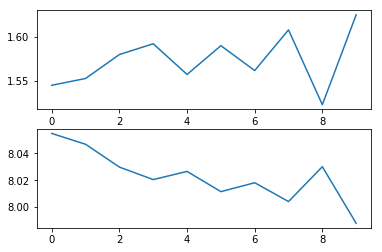

In [147]:
# Visualize training graphs
plt.subplot(211)
plt.plot(train_history)
plt.subplot(212)
plt.plot(loss_history)

# Визуализируем вектора для разного вида слов до и после тренировки

В случае успешной тренировки вы должны увидеть как вектора слов разных типов (например, знаков препинания, предлогов и остальных) разделяются семантически.

Студенты - в качестве выполненного задания присылайте notebook с диаграммами!

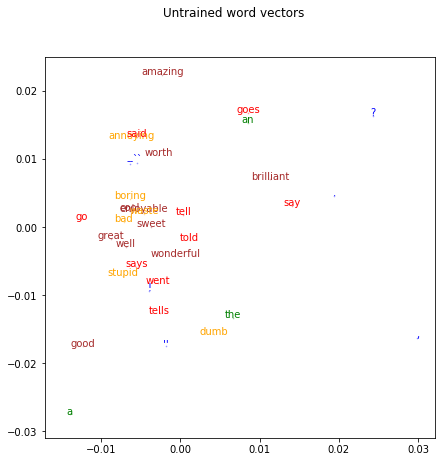

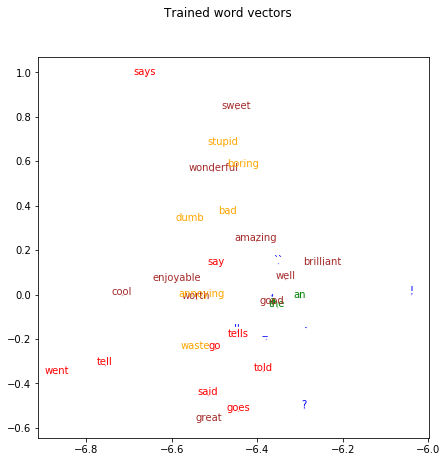

In [148]:
trained_input_vectors, trained_output_vectors = extract_word_vectors(nn_model)
assert trained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert trained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

def visualize_vectors(input_vectors, output_vectors, title=''):
    full_vectors = torch.cat((input_vectors.cpu(), output_vectors.cpu()), 0)
    wordvec_embedding = PCA(n_components=2).fit_transform(full_vectors.detach().numpy())

    # Helpful words form CS244D example
    # http://cs224d.stanford.edu/assignment1/index.html
    visualize_words = {'green': ["the", "a", "an"], 
                      'blue': [",", ".", "?", "!", "``", "''", "--"], 
                      'brown': ["good", "great", "cool", "brilliant", "wonderful", 
                              "well", "amazing", "worth", "sweet", "enjoyable"],
                      'orange': ["boring", "bad", "waste", "dumb", "annoying", "stupid"],
                      'red': ['tell', 'told', 'said', 'say', 'says', 'tells', 'goes', 'go', 'went']
                     }

    plt.figure(figsize=(7,7))
    plt.suptitle(title)
    for color, words in visualize_words.items():
        points = np.array([wordvec_embedding[data.index_by_token[w]] for w in words])
        for i, word in enumerate(words):
            plt.text(points[i, 0], points[i, 1], word, color=color,horizontalalignment='center')
        plt.scatter(points[:, 0], points[:, 1], c=color, alpha=0.3, s=0.5)

visualize_vectors(untrained_input_vectors, untrained_output_vectors, "Untrained word vectors")
visualize_vectors(trained_input_vectors, trained_output_vectors, "Trained word vectors")